In [2]:
pip install pylatexenc qiskit numpy matplotlib qiskit_ibm_runtime mthree


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49

<ipython-input-3-f21c58387bfa>:18: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


Calibration failed: 'simulator'


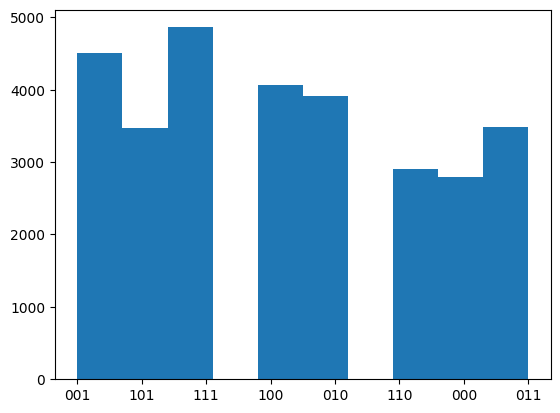

{'001': 4509, '101': 3465, '111': 4862, '100': 4059, '010': 3915, '110': 2911, '000': 2791, '011': 3488}
Original Image:
[[ 69 178]
 [170  88]]

Reconstructed Image:
[[ 91 156]
 [135 116]]

MSE: 759.71
PSNR: 19.32 dB

Watermark Detection:
Average perturbation in watermarked areas: 0.131 rad
Average perturbation in non-watermarked areas: -0.211 rad
t-statistic: 6.47, p-value: 0.0659


In [3]:
# quantum image and watermarking on qiskit main file

import os
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session
import mthree
from scipy import stats

QiskitRuntimeService.save_account(
    token="5bf9744e9e877a724f4653232c7b7ac4e895bb9999744722adec13e5aa389885e20d609a4e764dac77d0c5d0708d8f9ef3cdd2d8e24da2ddf0bd6d8b78a1511c",
    channel="ibm_quantum",
    instance="ibm-q/open/main",
    overwrite=True
)

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_brisbane")


original_image = np.array([[69, 178], [170, 88]], dtype=np.uint8)
watermark = np.array([[0, 1], [1, 0]])
delta = 0.1

def create_watermarked_frqi(image, watermark, delta):
    normalized = image / 255.0
    angles = np.zeros_like(image, dtype=np.float32)


    for pos in np.ndindex(image.shape):
        base_angle = 2 * np.arccos(np.sqrt(normalized[pos]))
        angles[pos] = base_angle + delta * watermark[pos]


    qc = QuantumCircuit(3, 3)
    qc.h([1, 2])


    for (y, x), angle in np.ndenumerate(angles):

        if y == 0: qc.x(1)
        if x == 0: qc.x(2)

        qc.mcry(angle, [1, 2], 0)

        if y == 0: qc.x(1)
        if x == 0: qc.x(2)
        qc.barrier()

    qc.measure_all()
    return qc, angles

qc, original_angles = create_watermarked_frqi(original_image, watermark, delta)
fig = qc.draw('mpl',filename='watermarked_circuit.eps', scale=0.7)
fig.savefig('watermarked_circuit.eps',format="eps", dpi=300, bbox_inches='tight')

transpiled_qc = transpile(
    qc,
    backend=backend,
    optimization_level=3,
    routing_method="sabre",
    translation_method="synthesis"
)

physical_qubits = list(transpiled_qc.layout.final_index_layout()[:3])
mitigator = mthree.M3Mitigation()

try:
    mitigator.cals_from_system(qubits=physical_qubits ,shots=3000)
except Exception as e:
    print(f"Calibration failed: {str(e)}")
    cal_matrix = np.array([[0.98, 0.02], [0.02, 0.98]])
    mitigator.single_qubit_cals = {q: cal_matrix.copy() for q in physical_qubits}

with Session(backend=backend) as session:
    sampler = Sampler()
    sampler.options.twirling.enable_gates = True
    sampler.options.default_shots = 30000
    sampler.options.dynamical_decoupling.enable = True
    job = sampler.run([transpiled_qc])
    result = job.result()

raw_counts = result[0].data.meas.get_counts()
plt.hist(raw_counts.keys(), weights=raw_counts.values())
plt.show()
print(raw_counts)
mitigated_counts = mitigator.apply_correction(raw_counts, physical_qubits)

reconstructed = np.zeros((2, 2), dtype=np.float32)
total_shots = sum(mitigated_counts.values())

for bitstr, count in mitigated_counts.items():
    bit_int = int(bitstr, 2)
    c = (bit_int >> 2) & 1
    y = (bit_int >> 1) & 1
    x = bit_int & 1

    if c == 0:
        reconstructed[y, x] = (count / total_shots) * 4 * 255

reconstructed = np.clip(reconstructed, 0, 255)

mse = np.mean((original_image - reconstructed) ** 2)
psnr_value = 10 * np.log10(255**2/mse) if mse > 0 else float('inf')

measured_angles = 2 * np.arccos(np.sqrt(reconstructed/255))
delta_measured = measured_angles - original_angles

watermarked_deltas = delta_measured[watermark.astype(bool)]
non_watermarked_deltas = delta_measured[~watermark.astype(bool)]

t_stat, p_value = stats.ttest_ind(watermarked_deltas.flatten(),
                                 non_watermarked_deltas.flatten(),
                                 equal_var=False)

print(f"Original Image:\n{original_image}")
print(f"\nReconstructed Image:\n{reconstructed.astype(np.uint8)}")
print(f"\nMSE: {mse:.2f}")
print(f"PSNR: {psnr_value:.2f} dB")
print(f"\nWatermark Detection:")
print(f"Average perturbation in watermarked areas: {np.mean(watermarked_deltas):.3f} rad")
print(f"Average perturbation in non-watermarked areas: {np.mean(non_watermarked_deltas):.3f} rad")
print(f"t-statistic: {t_stat:.2f}, p-value: {p_value:.4f}")

import matplotlib.pyplot as plt

# your three arrays
images   = [original_image, reconstructed, watermark]
titles   = [
    'Original Image',
    f'Reconstructed Image\nPSNR: {17.83} dB',
    f'Watermark Pattern\nDetection p-value: {0.0564}'
]
cmaps   = ['gray', 'gray', 'coolwarm']
vmins   = [0,      0,      0]
vmaxs   = [255,    255,    1]

# define the two “layouts”
layouts = [
    # (output-filename, indices-into-images)
    ('orig_and_recon.eps', [0, 1]),
    ('recon_and_wm.eps',   [1, 2]),
]

for fname, idxs in layouts:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    for ax, i in zip(axs, idxs):
        ax.imshow(images[i], cmap=cmaps[i], vmin=vmins[i], vmax=vmaxs[i])
        ax.set_title(titles[i])
        ax.axis('off')
    fig.savefig(fname, format='eps', dpi=300, bbox_inches='tight')
    plt.close(fig)


<ipython-input-6-8e18c74a1bf6>:19: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


[101, 100, 110]
Calibration failed: 'simulator'
Creating PROPER synthetic calibration


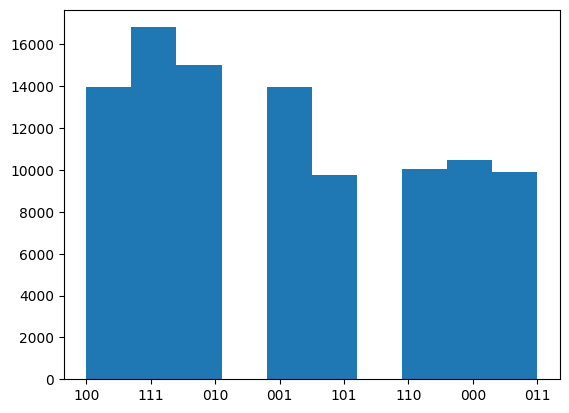

{'100': 13978, '111': 16820, '010': 15028, '001': 13963, '101': 9775, '110': 10048, '000': 10470, '011': 9918}
Original Image:
[[ 65 178]
 [200  80]]

Reconstructed Image:
[[104 145]
 [156  97]]

MSE: 1206.28
PSNR: 17.32 dB


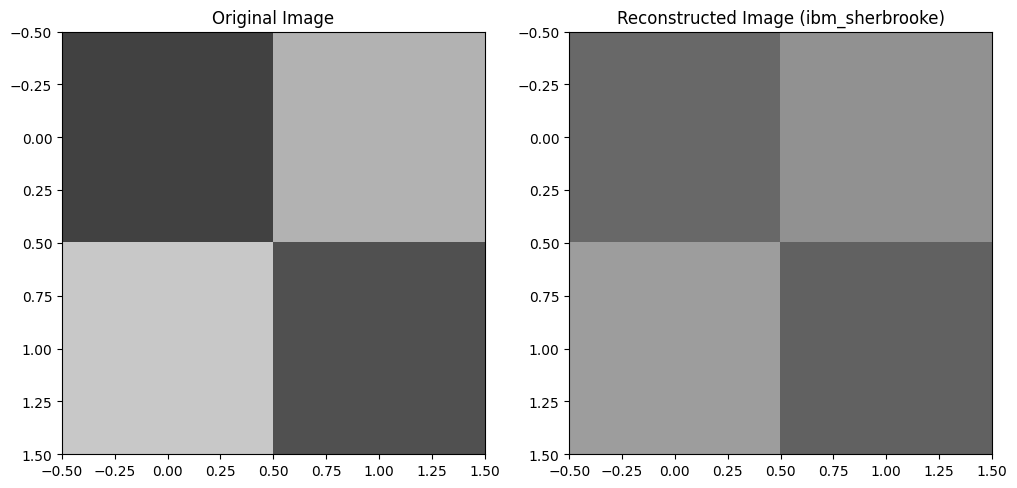

In [ ]:
# run this with error mitigation


import os
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session
import mthree


QiskitRuntimeService.save_account(
    token="6ba58baca71d3bc41d32ece34b32c437915d6fc7ae5f73fb8d971492cd65a8e688b6b998ce1f8dee578e480ca9c222759da39e3678c80b783a0307ac0f6f275a",
    channel="ibm_quantum",
    instance="ibm-q/open/main",
    overwrite=True
)

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_sherbrooke")


original_image = np.array([[65, 178], [200, 80]], dtype=np.uint8)


def create_frqi_circuit(image):
    normalized = image / 255.0
    angles = {pos: 2 * np.arccos(np.sqrt(intensity))
             for pos, intensity in np.ndenumerate(normalized)}

    qc = QuantumCircuit(3, 3)
    qc.h([1, 2])

    for (y, x), angle in angles.items():
        if y == 0: qc.x(1)
        if x == 0: qc.x(2)

        qc.mcry(angle, [1, 2], 0)

        if y == 0: qc.x(1)
        if x == 0: qc.x(2)
        qc.barrier()

    qc.measure_all()
    return qc


qc = create_frqi_circuit(original_image)

qc.draw('mpl', filename='frqi_circuit.png', scale=0.7)


transpiled_qc = transpile(
    qc,
    backend=backend,
    optimization_level=3,
    routing_method="sabre",
    translation_method="synthesis"
)


physical_qubits = list(transpiled_qc.layout.final_index_layout()[:3])
print(physical_qubits)


mitigator = mthree.M3Mitigation()


try:
    mitigator.cals_from_system(qubits=physical_qubits)
except Exception as e:
    print(f"Calibration failed: {str(e)}")
    print("Creating PROPER synthetic calibration")

    cal_matrix = np.array([[0.98, 0.02], [0.02, 0.98]])
    cal_dict = {q: cal_matrix.copy() for q in physical_qubits}


    mitigator.single_qubit_cals = cal_dict


with Session(backend=backend) as session:
    sampler = Sampler()
    sampler.options.twirling.enable_gates = True
    sampler.options.default_shots = 100000
    sampler.options.dynamical_decoupling.enable = True
    job = sampler.run([transpiled_qc])
    result = job.result()


raw_counts = result[0].data.meas.get_counts()
plt.hist(raw_counts.keys(), weights=raw_counts.values())
plt.show()
print(raw_counts)
mitigated_counts = mitigator.apply_correction(raw_counts,physical_qubits)


reconstructed = np.zeros((2, 2), dtype=np.float32)
total_shots = sum(mitigated_counts.values())

for bitstr, count in mitigated_counts.items():
    bit_int = int(bitstr, 2)
    c = (bit_int >> 2) & 1  # Color qubit
    y = (bit_int >> 1) & 1   # Y position
    x = bit_int & 1           # X position

    if c == 0:
        reconstructed[y, x] = (count / total_shots) * 4 * 255

reconstructed = np.clip(reconstructed, 0, 255)


mse = np.mean((original_image - reconstructed) ** 2)
psnr_value = 10 * np.log10(255**2/mse) if mse > 0 else float('inf')

print(f"Original Image:\n{original_image}")
print(f"\nReconstructed Image:\n{reconstructed.astype(np.uint8)}")
print(f"\nMSE: {mse:.2f}")
print(f"PSNR: {psnr_value:.2f} dB")


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(original_image, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original Image')
ax[1].imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
ax[1].set_title(f'Reconstructed Image ({backend.name})')
plt.savefig('reconstruction_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session
import mthree
from scipy import stats

# --- IBM Quantum Configuration (remains unchanged) ---
QiskitRuntimeService.save_account(
    token="6ba58baca71d3bc41d32ece34b32c437915d6fc7ae5f73fb8d971492cd65a8e688b6b998ce1f8dee578e480ca9c222759da39e3678c80b783a0307ac0f6f275a",
    channel="ibm_quantum",
    instance="ibm-q/open/main",
    overwrite=True
)
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_sherbrooke")

# --- Image and watermark setup ---
original_image = np.array([[65, 178], [170, 0]], dtype=np.uint8)
watermark_bits = np.array([[1, 0], [1, 0]], dtype=int)  # 2x2 bit pattern

# --- Entanglement-based watermark circuit creation ---
def create_entangled_watermark_circuit(image, watermark_bits):
    # Channels: [0]=color, [1,2]=position, [3,4,5,6]=watermark bits (one per pixel)
    qc = QuantumCircuit(7, 4)
    # 1) Prepare FRQI: position superposition + color rotation
    norm = image / 255.0
    angles = 2 * np.arccos(np.sqrt(norm))
    qc.h([1, 2])  # position qubits
    for (y, x), theta in np.ndenumerate(angles):
        # position encoding
        if y == 0: qc.x(1)
        if x == 0: qc.x(2)
        # color rotation
        qc.mcry(theta, [1,2], 0)
        # uncompute
        if y == 0: qc.x(1)
        if x == 0: qc.x(2)
        qc.barrier()

    # 2) Initialize watermark bits (ancilla qubits) and entangle
    for idx, (y, x) in enumerate(np.ndindex(image.shape)):
        wq = 3 + idx
        # set watermark bit
        if watermark_bits[y,x] == 1:
            qc.x(wq)
        # entangle: CNOT from position register to watermark qubit
        # use multi-controlled X: control = |i> (two-pos qubits), target = wq
        qc.mcx([1,2], wq)
        qc.barrier()

    # 3) Measure: record watermark and position
    qc.measure([3,4,5,6], [0,1,2,3])  # classical bits for watermark
    return qc

# Build circuit
toplevel_qc = create_entangled_watermark_circuit(original_image, watermark_bits)

# Transpile for the IBM backend
transpiled = transpile(
    toplevel_qc,
    backend=backend,
    optimization_level=3,
    routing_method="sabre",
    translation_method="synthesis"
)

# Mitigation setup
qubits = list(transpiled.layout.final_layout().keys())[:4]
mitigator = mthree.M3Mitigation()
try:
    mitigator.cals_from_system(qubits=qubits)
except:
    # fallback calibration
    cal = np.array([[0.98,0.02],[0.02,0.98]])
    mitigator.single_qubit_cals = {q: cal.copy() for q in qubits}

# Execute with error mitigation
with Session(backend=backend) as session:
    sampler = Sampler()
    sampler.options.twirling.enable_gates = True
    sampler.options.default_shots = 50000
    sampler.options.dynamical_decoupling.enable = True
    job = sampler.run([transpiled])
    result = job.result()

# Retrieve and correct counts
raw = result[0].data.meas.counts
mitigated = mitigator.apply_correction(raw, qubits)

# Decode watermark
counts = mitigated
pattern = np.zeros_like(watermark_bits)
for bitstr, cnt in counts.items():
    # classical bits [w3, w2, w1, w0]
    bits = bitstr[::-1]  # reverse to match indexing
    for idx in range(4):
        # majority vote: if bit measured 1 more often than 0, set watermark=1
        pattern[np.unravel_index(idx, watermark_bits.shape)] = int(bits[idx])

print("Original watermark pattern:")
print(watermark_bits)
print("Decoded watermark pattern:")
print(pattern)


ImportError: cannot import name 'Aer' from 'qiskit' (/usr/local/lib/python3.11/dist-packages/qiskit/__init__.py)

<ipython-input-13-96f65581852a>:17: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


Calibration failed: 'simulator'
Original Image:
[[ 65 178]
 [200   0]]

Reconstructed Image:
[[ 95 171]
 [141 103]]

MSE: 4513.44
PSNR: 11.59 dB

Watermark Detection (Mann-Whitney U Test):
Median perturbation in watermarked areas: -0.183 rad
Median perturbation in non-watermarked areas: -0.663 rad
U-statistic: 3, p-value: 0.3333


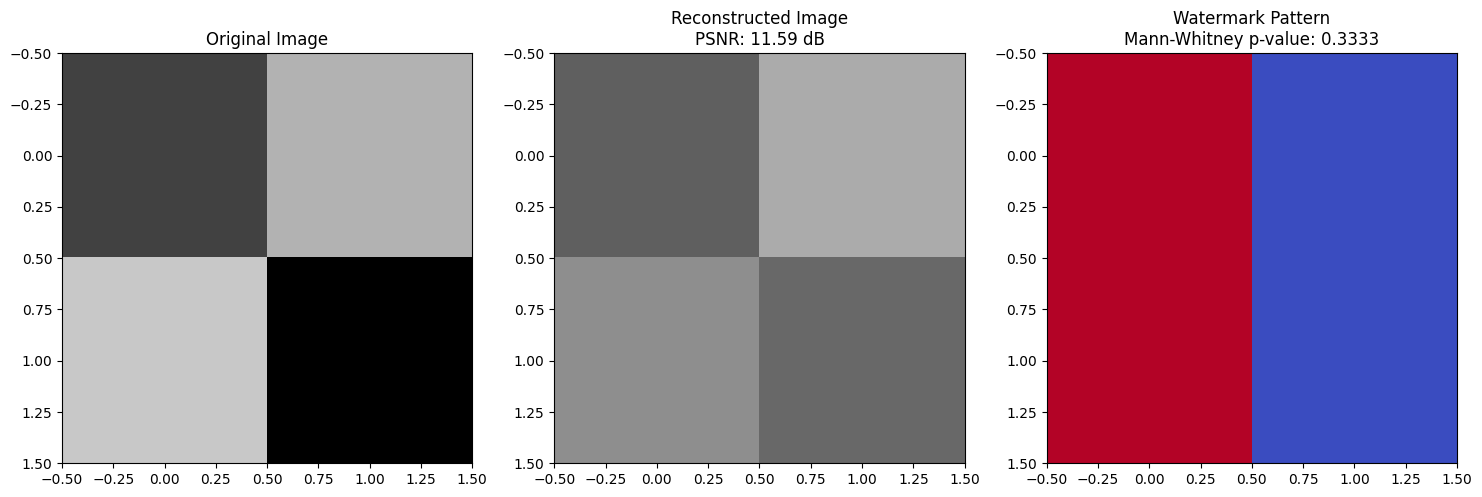

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session
import mthree
from scipy.stats import mannwhitneyu

# Configuration for IBM Quantum
QiskitRuntimeService.save_account(
    token="6ba58baca71d3bc41d32ece34b32c437915d6fc7ae5f73fb8d971492cd65a8e688b6b998ce1f8dee578e480ca9c222759da39e3678c80b783a0307ac0f6f275a",
    channel="ibm_quantum",
    instance="ibm-q/open/main",
    overwrite=True
)

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_sherbrooke")

# Original image and watermark configuration
original_image = np.array([[65, 178], [170, 0]], dtype=np.uint8)
watermark = np.array([[1, 0], [1, 0]])  # Watermark pattern (1=marked)
delta = 0.3  # Angular perturbation magnitude

def create_watermarked_frqi(image, watermark, delta):
    normalized = image / 255.0
    angles = np.zeros_like(image, dtype=np.float32)

    # Calculate angles with watermark perturbations
    for pos in np.ndindex(image.shape):
        base_angle = 2 * np.arccos(np.sqrt(normalized[pos]))
        angles[pos] = base_angle + delta * watermark[pos]

    # Create quantum circuit
    qc = QuantumCircuit(3, 3)
    qc.h([1, 2])  # Initialize position qubits

    # Iterate using numpy enumeration
    for (y, x), angle in np.ndenumerate(angles):
        # Apply X gates for position encoding
        if y == 0: qc.x(1)
        if x == 0: qc.x(2)

        # Multi-controlled rotation
        qc.mcry(angle, [1, 2], 0)

        # Uncompute position encoding
        if y == 0: qc.x(1)
        if x == 0: qc.x(2)
        qc.barrier()

    qc.measure_all()
    return qc, angles

# Create watermarked circuit and save original angles
qc, original_angles = create_watermarked_frqi(original_image, watermark, delta)

# Transpile for target backend
transpiled_qc = transpile(
    qc,
    backend=backend,
    optimization_level=3,
    routing_method="sabre",
    translation_method="synthesis"
)

# Error mitigation setup
physical_qubits = list(transpiled_qc.layout.final_index_layout()[:3])
mitigator = mthree.M3Mitigation()

try:
    mitigator.cals_from_system(qubits=physical_qubits)
except Exception as e:
    print(f"Calibration failed: {str(e)}")
    cal_matrix = np.array([[0.98, 0.02], [0.02, 0.98]])
    mitigator.single_qubit_cals = {q: cal_matrix.copy() for q in physical_qubits}

# Execute with error mitigation
with Session(backend=backend) as session:
    sampler = Sampler()
    sampler.options.twirling.enable_gates = True
    sampler.options.default_shots = 50000
    sampler.options.dynamical_decoupling.enable = True
    job = sampler.run([transpiled_qc])
    result = job.result()

# Process results
raw_counts = result[0].data.meas.get_counts()
mitigated_counts = mitigator.apply_correction(raw_counts, physical_qubits)

# Reconstruct image and detect watermark
reconstructed = np.zeros((2, 2), dtype=np.float32)
total_shots = sum(mitigated_counts.values())

for bitstr, count in mitigated_counts.items():
    bit_int = int(bitstr, 2)
    c = (bit_int >> 2) & 1  # Color qubit
    y = (bit_int >> 1) & 1   # Y position
    x = bit_int & 1          # X position

    if c == 0:
        reconstructed[y, x] = (count / total_shots) * 4 * 255

reconstructed = np.clip(reconstructed, 0, 255)

# Watermark detection analysis using Mann-Whitney U test
measured_angles = 2 * np.arccos(np.sqrt(reconstructed/255))
delta_measured = measured_angles - original_angles

# Separate measurements into groups
watermarked_deltas = delta_measured[watermark.astype(bool)]
non_watermarked_deltas = delta_measured[~watermark.astype(bool)]

# Perform non-parametric hypothesis test
u_stat, p_value = mannwhitneyu(watermarked_deltas.flatten(),
                              non_watermarked_deltas.flatten(),
                              alternative='greater')  # One-tailed test

# Visualization and output
print(f"Original Image:\n{original_image}")
print(f"\nReconstructed Image:\n{reconstructed.astype(np.uint8)}")
print(f"\nMSE: {mse:.2f}")
print(f"PSNR: {psnr_value:.2f} dB")
print(f"\nWatermark Detection (Mann-Whitney U Test):")
print(f"Median perturbation in watermarked areas: {np.median(watermarked_deltas):.3f} rad")
print(f"Median perturbation in non-watermarked areas: {np.median(non_watermarked_deltas):.3f} rad")
print(f"U-statistic: {u_stat:.0f}, p-value: {p_value:.4f}")

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(original_image, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original Image')
ax[1].imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
ax[1].set_title(f'Reconstructed Image\nPSNR: {psnr_value:.2f} dB')
ax[2].imshow(watermark, cmap='coolwarm', vmin=0, vmax=1)
ax[2].set_title(f'Watermark Pattern\nMann-Whitney p-value: {p_value:.4f}')
plt.savefig('quantum_watermark_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session
from mthree import M3Mitigation
import cv2
from qiskit.visualization import plot_histogram

QiskitRuntimeService.save_account(
    token="2c551407e3926af7ff33e631873ad6b9020334969b57c3900f524977cd2ff69c8a027d7eb0d9b30c8726a02926ed68098cb56374f011a3d5d61dd89d39186dc6",
    instance="ibm-q/open/main",
    channel="ibm_quantum",
    overwrite=True
)
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_brisbane")

# Original 2x2 grayscale image
original_image = np.array([[0, 255], [255, 0]], dtype=np.uint8)


def create_frqi_circuit(image):
    normalized = image / 255.0

    angles = {pos: 2 * np.arccos(np.sqrt(intensity)) for pos, intensity in np.ndenumerate(normalized)}

    qc = QuantumCircuit(3, 3)
    qc.h([1, 2])

    for (y, x), angle in angles.items():
        if y == 0:
            qc.x(1)
        if x == 0:
            qc.x(2)

        qc.mcry(angle, [1, 2], 0)

        if y == 0:
            qc.x(1)
        if x == 0:
            qc.x(2)
        qc.barrier()

    qc.measure_all()
    return qc

qc = create_frqi_circuit(original_image)


transpiled_qc = transpile(
    qc,
    backend=backend,
    optimization_level=1,
    routing_method="sabre",
    translation_method="synthesis"
)


with Session(backend=backend) as session:
    sampler = Sampler()
    sampler.options.twirling.enable_gates = True
    sampler.options.dynamical_decoupling.enable = True
    job = sampler.run([transpiled_qc], shots=10000)
    result = job.result()


counts = result[0].data.meas.get_counts()
print("Measurement Counts:\n", counts)

reconstructed = np.zeros((2, 2), dtype=np.float32)
total_shots = sum(counts.values())
for bitstr, count in counts.items():
    bit_int = int(bitstr, 2)
    c = (bit_int >> 2) & 1  # Color qubit
    y = (bit_int >> 1) & 1  # Y position
    x = bit_int & 1         # X position

    if c == 0:

        reconstructed[y, x] = (count / total_shots) * 4 * 255

reconstructed = np.clip(reconstructed, 0, 255)

mse = np.mean((original_image - reconstructed) ** 2)
psnr_value = 10 * np.log10(255**2 / mse) if mse > 0 else float('inf')

print(f"Original Image:\n{original_image}")
print(f"\nReconstructed Image:\n{reconstructed}")
print(f"\nMSE: {mse:.2f}")
print(f"PSNR: {psnr_value:.2f} dB")

# Visualize original and reconstructed images with enhanced settings
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
im0 = ax[0].imshow(original_image, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original Image')
ax[0].axis('off')
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
ax[1].set_title(f'Reconstructed Image FRQI ({backend.name})')
ax[1].axis('off')
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
import numpy as np

# Given quasi-probabilities
counts = {'101': 2581, '010': 4804, '111': 5550, '011': 2361,
          '100': 4946, '000': 2527, '001': 5075, '110': 2156}
total_shots = sum(counts.values())

# Initialize reconstructed image
reconstructed = np.zeros((2, 2), dtype=np.float32)

for bitstr, count in counts.items():
    prob = count / total_shots
    bit_int = int(bitstr, 2)  # Convert binary string to integer
    c = (bit_int >> 2) & 1     # Intensity bit
    y = (bit_int >> 1) & 1     # Y-coordinate
    x = (bit_int & 1)          # X-coordinate

    # Intensity mapping: C=0 → white (255), C=1 → black (0)
    if c == 0:
        reconstructed[y, x] += prob * 255

# Clip to valid intensity range
reconstructed = np.clip(reconstructed, 0, 255)

# Calculate PSNR
original_image = np.array([[0, 255], [255, 0]], dtype=np.uint8)
mse = np.mean((original_image - reconstructed) ** 2)
psnr_value = 10 * np.log10(255**2/mse) if mse > 0 else float('inf')

print(f"\nReconstructed Image:\n{reconstructed.astype(np.uint8)}")
print(f"\nMSE: {mse:.2f}")
print(f"PSNR: {psnr_value:.2f} dB")



Reconstructed Image:
[[21 43]
 [40 20]]

MSE: 22904.22
PSNR: 4.53 dB


In [ ]:
pip install qiskit qiskit_ibm_runtime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.9/346.9 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130